In [1]:
#!pip install scikit-learn --force
#!pip install catboost

In [2]:
import sys
sys.path.append('../..')
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import os

pd.set_option('display.max.columns', 300)



from core.definitions import *

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
# если хотим обучить модели

#spark = run_spark_session('check_calc')

spark = None #если без обучения

In [4]:
ENV_NAME = 'hmelevskoi_env'

os.environ['CC'] = 'x86_64-conda-linux-gnu-gcc'
os.environ['CXX'] = 'x86_64-conda-linux-gnu-g++'
os.environ['PATH'] = os.path.abspath(f'/tmp/envs/{ENV_NAME}/bin') + ':' + os.environ['PATH']

In [5]:
# engine.calc_results['CurrentAccounts'] # расчетные счета

## Калькулятор маржи

## Чтение ретро портфелей и создание выборки

In [6]:
# сначала вертикально конкатируем

In [7]:
# port

In [8]:
BUCKETED_BALANCE_MAP_ = {
    1: '<100k',
    2: '100k-400k',
    3: '400k-1000k',
    4: '1000k-2000k',
    5: '>2000k'
}

In [9]:
portfolio_result_cols = [
    'report_dt', 'segment', 'replenishable_flg', 'subtraction_flg', 'month_maturity','target_maturity_days', 'bucketed_balance_nm', 'bucketed_balance', 'open_month', 'close_month', 
    'weight_rate', 'balance', 'renewal_cnt', 'operations_in_month', 'early_withdrawal_in_month', 'gen_name'
    ]

In [10]:
def _add_cols_to_port(port):
    port = port.copy()
    port.loc[:, 'replenishable_flg'] = port['optional_flg'].isin([2,3]).astype(int)
    port.loc[:, 'subtraction_flg'] = port['optional_flg'].isin([1,3]).astype(int)
    port.loc[:, 'segment'] = port['is_vip_or_prv'].apply(lambda x: SEGMENT_MAP_[x])
    port.loc[:, 'month_maturity'] =  (port['bucketed_period'] - 1).astype(int)
    port.loc[:, 'target_maturity_days'] =  port.month_maturity.apply(month_to_target_maturity) 
    return port

In [11]:
def _portfolio_result(port):
    port['bucketed_balance_nm'] = port.bucketed_balance.apply(
        lambda x: BUCKETED_BALANCE_MAP_[x] if x in BUCKETED_BALANCE_MAP_ else '<100k'
    )
    port.loc[:, 'renewal_cnt'] = port.weight_renewal_cnt.round()
    port.loc[:, 'operations_in_month'] = np.where(port.optional_flg > 0, port.SER_d_cl, 0)
    port.loc[:, 'early_withdrawal_in_month'] = np.where(port.optional_flg == 0, port.SER_d_cl, 0)
    port.loc[:, 'balance'] = port.loc[:, 'total_generation']

    #port = port[port['report_dt']>self._forecast_context.portfolio_dt+MonthEnd(-1)]
    return port.sort_values(
        by = ['report_dt', 'segment', 'replenishable_flg', 'subtraction_flg', 'balance'],ascending = [True, True, True, True, False], ignore_index = True
    )

In [12]:
port_res = []

for i in range(1, 8, 1):
    #print(i)
    
    port = pd.read_csv(f'/home/vtb70186744/dynbalance/data/portfolio_data/portfolio_2023-0{i}.csv', parse_dates=True)
    port['report_dt'] = pd.to_datetime(port['report_dt'])

    port_res.append(port)

In [13]:
port.sum()['total_interests'] / 10**9

156.13730427985934

In [14]:
port_res = pd.concat(port_res).reset_index(drop=True)

In [15]:
port_res = _add_cols_to_port(port_res)

In [16]:
port_res = _portfolio_result(port_res)

In [17]:
port_res.head(3)

,report_month,bucketed_balance,is_vip_or_prv,drop_flg,optional_flg,bucketed_period,open_month,close_month,bucketed_open_rate,report_dt,total_interests,remaining_interests,weight_rate,total_generation,total_generation_cleared,weight_renewal_cnt,weight_renewal_available_flg,weight_close_plan_day,gen_name,SER_d,SER_d_cl,SER_dinamic,SER_dinamic_cl,total_generation_lag1,total_generation_cl_lag1,CUR,report_weight_open_rate_1m,report_weight_open_rate_3m,report_weight_open_rate_6m,report_weight_open_rate_12m,report_weight_open_rate_24m,report_wo_period_weight_open_rate,init_total_generation,row_count,share_period_plan,max_total_generation,max_SER_dinamic,replenishable_flg,subtraction_flg,segment,month_maturity,target_maturity_days,bucketed_balance_nm,renewal_cnt,operations_in_month,early_withdrawal_in_month,balance
0,2023-01,4.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.080998e+09,4.309770e+08,7.014158,3.767463e+10,3.689392e+10,0.0,0.0,7.640179,2022-09_2023-03_4.0_7.0_8.0_0_0_0.0_RUR,-1.498874e+08,-3.443082e+08,-0.003963,-0.009246,3.782452e+10,3.723822e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,4.033852e+10,5,0.674033,3.767463e+10,-0.003963,0,0,mass,6,180,1000k-2000k,0.0,0.0,-3.443082e+08,3.767463e+10
1,2023-01,3.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.039290e+09,4.140946e+08,7.014465,3.624522e+10,3.546236e+10,0.0,0.0,7.765046,2022-09_2023-03_3.0_7.0_8.0_0_0_0.0_RUR,4.100963e+07,-1.568994e+08,0.001133,-0.004405,3.620421e+10,3.561926e+10,RUR,NaN,7.0,7.490077,7.450225,NaN,7.355351,3.720755e+10,5,0.674033,3.624522e+10,0.001133,0,0,mass,6,180,400k-1000k,0.0,0.0,-1.568994e+08,3.624522e+10
2,2023-01,4.0,0,0.0,0.0,13.0,2022-09,2023-09,8.0,2023-01-31,7.430132e+08,1.515603e+09,7.000000,2.592414e+10,2.539205e+10,0.0,0.0,14.847356,2022-09_2023-09_4.0_13.0_8.0_0_0_0.0_RUR,-6.024040e+07,-1.934322e+08,-0.002318,-0.007560,2.598438e+10,2.558548e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,2.814998e+10,5,0.334247,2.592414e+10,-0.002318,0,0,mass,12,365,1000k-2000k,0.0,0.0,-1.934322e+08,2.592414e+10


In [18]:
port_res.groupby('report_dt').sum()['balance']

report_dt
2023-01-31    2.950907e+12
2023-02-28    3.000243e+12
2023-03-31    3.044367e+12
2023-04-30    3.077628e+12
2023-05-31    3.131640e+12
2023-06-30    3.148000e+12
2023-07-31    2.990741e+12
Name: balance, dtype: float64

In [19]:
port_res['interests'] = port_res['total_generation'] - port_res['total_generation_lag1'].astype(float) - port_res['SER_d_cl']

In [21]:
portfolio_res = port_res.copy()

In [22]:
portfolio_res['open_month_correct'] = pd.to_datetime(portfolio_res['open_month'], format='%Y-%m')

In [23]:
portfolio_res['month_maturity'].unique()

array([   6,   12,    3,    9,   36,   18,   61,   24,    7,   13,   60,
         57,   48,    4,   15,   16,   20,   10,   42,   54,   22,   28,
         11,   40,   33,   21,   32,   23,   51,   37, 1826,   45,   19,
         44,    5,    8,   26,   14,   35,   31,   17,   52,   43,   85,
         30,   25,   29,   49,   58,   34])

##### 

In [24]:
portfolio_res['target_maturity_days'].unique()

array([ 180,  365,   90, 1095,  548,  730])

In [25]:
maturity_dict = {90: 3,
                180: 6,
                365: 12,
                548: 18,
                730: 24,
                1095: 36}

In [26]:
# корректируем месяца
portfolio_res['target_maturity_months'] = portfolio_res['target_maturity_days'].replace(maturity_dict)

Сделаем поле open_month_correct и нормальную дату открытия для каждого депозита

In [27]:
portfolio_res.head(3)

,report_month,bucketed_balance,is_vip_or_prv,drop_flg,optional_flg,bucketed_period,open_month,close_month,bucketed_open_rate,report_dt,total_interests,remaining_interests,weight_rate,total_generation,total_generation_cleared,weight_renewal_cnt,weight_renewal_available_flg,weight_close_plan_day,gen_name,SER_d,SER_d_cl,SER_dinamic,SER_dinamic_cl,total_generation_lag1,total_generation_cl_lag1,CUR,report_weight_open_rate_1m,report_weight_open_rate_3m,report_weight_open_rate_6m,report_weight_open_rate_12m,report_weight_open_rate_24m,report_wo_period_weight_open_rate,init_total_generation,row_count,share_period_plan,max_total_generation,max_SER_dinamic,replenishable_flg,subtraction_flg,segment,month_maturity,target_maturity_days,bucketed_balance_nm,renewal_cnt,operations_in_month,early_withdrawal_in_month,balance,interests,open_month_correct,target_maturity_months
0,2023-01,4.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.080998e+09,4.309770e+08,7.014158,3.767463e+10,3.689392e+10,0.0,0.0,7.640179,2022-09_2023-03_4.0_7.0_8.0_0_0_0.0_RUR,-1.498874e+08,-3.443082e+08,-0.003963,-0.009246,3.782452e+10,3.723822e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,4.033852e+10,5,0.674033,3.767463e+10,-0.003963,0,0,mass,6,180,1000k-2000k,0.0,0.0,-3.443082e+08,3.767463e+10,1.944209e+08,2022-09-01,6
1,2023-01,3.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.039290e+09,4.140946e+08,7.014465,3.624522e+10,3.546236e+10,0.0,0.0,7.765046,2022-09_2023-03_3.0_7.0_8.0_0_0_0.0_RUR,4.100963e+07,-1.568994e+08,0.001133,-0.004405,3.620421e+10,3.561926e+10,RUR,NaN,7.0,7.490077,7.450225,NaN,7.355351,3.720755e+10,5,0.674033,3.624522e+10,0.001133,0,0,mass,6,180,400k-1000k,0.0,0.0,-1.568994e+08,3.624522e+10,1.979090e+08,2022-09-01,6
2,2023-01,4.0,0,0.0,0.0,13.0,2022-09,2023-09,8.0,2023-01-31,7.430132e+08,1.515603e+09,7.000000,2.592414e+10,2.539205e+10,0.0,0.0,14.847356,2022-09_2023-09_4.0_13.0_8.0_0_0_0.0_RUR,-6.024040e+07,-1.934322e+08,-0.002318,-0.007560,2.598438e+10,2.558548e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,2.814998e+10,5,0.334247,2.592414e+10,-0.002318,0,0,mass,12,365,1000k-2000k,0.0,0.0,-1.934322e+08,2.592414e+10,1.331918e+08,2022-09-01,12


In [28]:
portfolio_res.renewal_cnt.unique()

array([ 0.,  1.,  4.,  2.,  8.,  9.,  7.,  5.,  6.,  3., 10., 11.])

In [29]:
portfolio_res['close_month_dt'] = pd.to_datetime(portfolio_res['close_month']) 

In [30]:
portfolio_res['open_month_correct'] = pd.to_datetime(portfolio_res['open_month']) 

In [31]:
portfolio_res['target_maturity_months'].unique()

array([ 6, 12,  3, 36, 18, 24])

In [32]:
for mat in portfolio_res['target_maturity_months'].unique():
    
    portfolio_res['open_month_correct'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)] = \
    portfolio_res['close_month_dt'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)] +  MonthEnd(-mat)
    
    
    portfolio_res['open_month'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)] = \
    portfolio_res['open_month_correct'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)].apply(lambda x: str(x)[:7])

<AxesSubplot:>

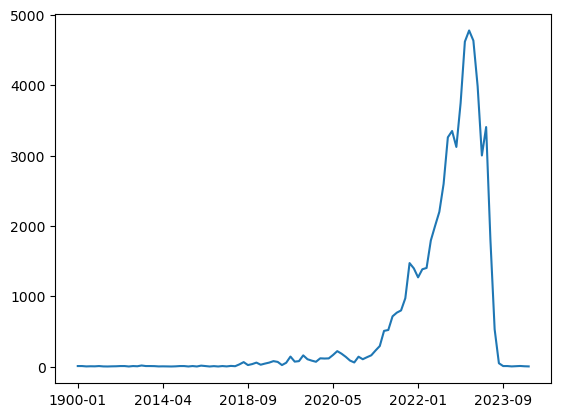

In [33]:
portfolio_res['open_month'].value_counts().sort_index().plot()

In [34]:
# 99 процентов занимают депозиты открытые позже 2017

portfolio_res[portfolio_res['open_month']>='2017-01']['balance'].sum() / portfolio_res['balance'].sum()

0.9999983267757493

### Джойним ftp ставки

In [35]:
# Код выгрузки

query = """
SELECT 
year(report_date) as report_year, 
month(report_date) as report_month, 
AVG(`vtb_[1095d]_ftp_rate`) as `VTB_[1095d]_ftp_rate`, 
AVG(`vtb_[180d]_ftp_rate`) as `VTB_[180d]_ftp_rate`,
AVG(`vtb_[365d]_ftp_rate`) as `VTB_[365d]_ftp_rate`,
AVG(`vtb_[548d]_ftp_rate`) as `VTB_[548d]_ftp_rate`,
AVG(`vtb_[730d]_ftp_rate`) as `VTB_[730d]_ftp_rate`,
AVG(`vtb_[90d]_ftp_rate`) as `VTB_[90d]_ftp_rate`

FROM dadm_alm_sbx.vtb_ftp_rates 

GROUP BY year(report_date), month(report_date)
ORDER BY year(report_date) desc, month(report_date) desc;
"""

In [36]:
ftp_table = pd.read_csv('ftp.csv')

In [37]:
ftp_table['report_month'][ftp_table['report_month']<=9] = ftp_table['report_month'][ftp_table['report_month']<=9].apply(lambda x: '0'+str(x))

In [38]:
ftp_table['report_month'] = ftp_table['report_month'].astype(str)

In [39]:
ftp_table['report_year'] = ftp_table['report_year'].astype(str)

In [40]:
ftp_table['open_month'] = ftp_table['report_year'] + '-' + ftp_table['report_month']

In [41]:
del ftp_table['report_month']
del ftp_table['report_year']

In [42]:
ftp_table

,vtb_[1095d]_ftp_rate,vtb_[180d]_ftp_rate,vtb_[365d]_ftp_rate,vtb_[548d]_ftp_rate,vtb_[730d]_ftp_rate,vtb_[90d]_ftp_rate,open_month
0,12.000000,12.000000,12.000000,12.000000,12.000000,12.257143,2023-09
1,11.130435,10.760870,10.913043,10.934783,10.956522,10.706522,2023-08
2,9.642857,8.578571,8.821429,9.050000,9.278571,8.407143,2023-07
3,9.500000,8.350000,8.550000,8.850000,9.150000,8.100000,2023-06
4,9.500000,8.300000,8.550000,8.850000,9.150000,8.050000,2023-05
...,...,...,...,...,...,...,...
217,8.410000,5.980000,NaN,NaN,NaN,NaN,2005-05
218,8.830000,6.520000,NaN,NaN,NaN,NaN,2005-04
219,8.580000,6.670000,NaN,NaN,NaN,NaN,2005-03
220,8.990000,7.470000,NaN,NaN,NaN,NaN,2005-02


In [43]:
# дополнить этот момент
# для новых вкладов лучше брать новые ставки

portfolio_res['open_month'][portfolio_res['open_month']>'2023-09'] = '2023-09'

portfolio_res = portfolio_res.merge(ftp_table, on='open_month', how='left')

In [44]:
portfolio_res['ftp'] = np.nan



for day in portfolio_res['target_maturity_days'].unique():
    
    # выбираем колонку
    col = f'vtb_[{day}d]_ftp_rate'
    
    portfolio_res['ftp'][portfolio_res['target_maturity_days']==day] = portfolio_res[col][portfolio_res['target_maturity_days']==day]

In [45]:
portfolio_res[portfolio_res['ftp'].isnull()]['balance'].sum()

8035796.890000001

In [46]:
portfolio_res[portfolio_res['ftp'].isnull()]['balance'].sum() / portfolio_res['balance'].sum()

3.7649811342871016e-07

In [47]:
portfolio_res[portfolio_res['ftp'].isnull()]['open_month'].value_counts().sort_index()

1900-01    7
1994-01    7
2005-02    2
2005-03    4
2005-04    3
2005-09    7
2007-01    2
2007-02    1
2009-02    1
2010-11    7
2011-05    4
2014-07    1
2017-03    2
Name: open_month, dtype: int64

формула для пролонгаций = дата открытия + срочность * число пролонгаций - это фактическая open_dt   

Можно подойти через плановая дата закрытия - срочность  

In [48]:
portfolio_res.head()

,report_month,bucketed_balance,is_vip_or_prv,drop_flg,optional_flg,bucketed_period,open_month,close_month,bucketed_open_rate,report_dt,total_interests,remaining_interests,weight_rate,total_generation,total_generation_cleared,weight_renewal_cnt,weight_renewal_available_flg,weight_close_plan_day,gen_name,SER_d,SER_d_cl,SER_dinamic,SER_dinamic_cl,total_generation_lag1,total_generation_cl_lag1,CUR,report_weight_open_rate_1m,report_weight_open_rate_3m,report_weight_open_rate_6m,report_weight_open_rate_12m,report_weight_open_rate_24m,report_wo_period_weight_open_rate,init_total_generation,row_count,share_period_plan,max_total_generation,max_SER_dinamic,replenishable_flg,subtraction_flg,segment,month_maturity,target_maturity_days,bucketed_balance_nm,renewal_cnt,operations_in_month,early_withdrawal_in_month,balance,interests,open_month_correct,target_maturity_months,close_month_dt,vtb_[1095d]_ftp_rate,vtb_[180d]_ftp_rate,vtb_[365d]_ftp_rate,vtb_[548d]_ftp_rate,vtb_[730d]_ftp_rate,vtb_[90d]_ftp_rate,ftp
0,2023-01,4.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.080998e+09,4.309770e+08,7.014158,3.767463e+10,3.689392e+10,0.0,0.0,7.640179,2022-09_2023-03_4.0_7.0_8.0_0_0_0.0_RUR,-1.498874e+08,-3.443082e+08,-0.003963,-0.009246,3.782452e+10,3.723822e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,4.033852e+10,5,0.674033,3.767463e+10,-0.003963,0,0,mass,6,180,1000k-2000k,0.0,0.0,-3.443082e+08,3.767463e+10,1.944209e+08,2022-09-01,6,2023-03-01,8.25,7.891304,8.0,8.1,8.15,7.847826,7.891304
1,2023-01,3.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.039290e+09,4.140946e+08,7.014465,3.624522e+10,3.546236e+10,0.0,0.0,7.765046,2022-09_2023-03_3.0_7.0_8.0_0_0_0.0_RUR,4.100963e+07,-1.568994e+08,0.001133,-0.004405,3.620421e+10,3.561926e+10,RUR,NaN,7.0,7.490077,7.450225,NaN,7.355351,3.720755e+10,5,0.674033,3.624522e+10,0.001133,0,0,mass,6,180,400k-1000k,0.0,0.0,-1.568994e+08,3.624522e+10,1.979090e+08,2022-09-01,6,2023-03-01,8.25,7.891304,8.0,8.1,8.15,7.847826,7.891304
2,2023-01,4.0,0,0.0,0.0,13.0,2022-09,2023-09,8.0,2023-01-31,7.430132e+08,1.515603e+09,7.000000,2.592414e+10,2.539205e+10,0.0,0.0,14.847356,2022-09_2023-09_4.0_13.0_8.0_0_0_0.0_RUR,-6.024040e+07,-1.934322e+08,-0.002318,-0.007560,2.598438e+10,2.558548e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,2.814998e+10,5,0.334247,2.592414e+10,-0.002318,0,0,mass,12,365,1000k-2000k,0.0,0.0,-1.934322e+08,2.592414e+10,1.331918e+08,2022-09-01,12,2023-09-01,8.25,7.891304,8.0,8.1,8.15,7.847826,8.000000
3,2023-01,3.0,0,0.0,0.0,13.0,2022-09,2023-09,8.0,2023-01-31,5.089354e+08,1.039455e+09,7.000000,1.776910e+10,1.738503e+10,0.0,0.0,15.224293,2022-09_2023-09_3.0_13.0_8.0_0_0_0.0_RUR,1.400735e+07,-8.303355e+07,0.000789,-0.004753,1.775509e+10,1.746806e+10,RUR,NaN,7.0,7.490077,7.450225,NaN,7.355351,1.879756e+10,5,0.334247,1.776910e+10,0.000789,0,0,mass,12,365,400k-1000k,0.0,0.0,-8.303355e+07,1.776910e+10,9.704090e+07,2022-09-01,12,2023-09-01,8.25,7.891304,8.0,8.1,8.15,7.847826,8.000000
4,2023-01,3.0,0,0.0,0.0,7.0,2022-09,2023-03,7.0,2023-01-31,4.124332e+08,1.643192e+08,6.334080,1.590330e+10,1.558651e+10,0.0,0.0,15.142723,2022-09_2023-03_3.0_7.0_7.0_0_0_0.0_RUR,2.768054e+07,-5.264548e+07,0.001744,-0.003366,1.587562e+10,1.563915e+10,RUR,NaN,7.0,7.490077,7.450225,NaN,7.355351,1.666473e+10,5,0.674033,1.590330e+10,0.001744,0,0,mass,6,180,400k-1000k,0.0,0.0,-5.264548e+07,1.590330e+10,8.032602e+07,2022-09-01,6,2023-03-01,8.25,7.891304,8.0,8.1,8.15,7.847826,7.891304


In [49]:
# agg_res.groupby('report_dt').sum()

default_rates = scenario_df[FTP_RATES_].values*(1- scenario_df[FOR_].values/100) - scenario_df[MARGIN_].values - scenario_df[SSV_].values

In [50]:
d = {'2023-01': [3], 
     '2023-02': [3], 
     '2023-03': [4], 
     '2023-04': [4], 
     '2023-05': [4], 
     '2023-06': [4.5],
     '2023-07': [4.5]}

In [51]:
FOR = pd.DataFrame(data=d, index=None).T

In [52]:
FOR = FOR.reset_index().rename(columns={'index': 'report_month', 0: 'FOR'})

In [53]:
portfolio_res = portfolio_res.merge(FOR, on='report_month', how='left')

In [78]:
portfolio_res['ftp'] = portfolio_res['ftp'] * (1 - portfolio_res['FOR']/100) #- portfolio_res['SSV']

In [79]:
#portfolio_res['FOR'] = 4.5
portfolio_res['SSV'] = 0.48

## Расчет маржи через долю

In [80]:
_REPORT_DT_COLUMN = 'report_dt'

In [81]:
GROUP_AGG_COLS = ['segment', 'replenishable_flg', 'subtraction_flg', 'target_maturity_days']

In [82]:
def _agg_interests(port, group_cols):
    old_port = port[port.total_generation_lag1 > 0]
    old_port['interests'] = old_port['total_generation'] - old_port['total_generation_lag1'].astype(float) - old_port['SER_d_cl']
    interests = old_port.groupby([_REPORT_DT_COLUMN, *group_cols])['interests'].sum().reset_index()
    return interests

In [83]:
portfolio_res.head(3)

,report_month,bucketed_balance,is_vip_or_prv,drop_flg,optional_flg,bucketed_period,open_month,close_month,bucketed_open_rate,report_dt,total_interests,remaining_interests,weight_rate,total_generation,total_generation_cleared,weight_renewal_cnt,weight_renewal_available_flg,weight_close_plan_day,gen_name,SER_d,SER_d_cl,SER_dinamic,SER_dinamic_cl,total_generation_lag1,total_generation_cl_lag1,CUR,report_weight_open_rate_1m,report_weight_open_rate_3m,report_weight_open_rate_6m,report_weight_open_rate_12m,report_weight_open_rate_24m,report_wo_period_weight_open_rate,init_total_generation,row_count,share_period_plan,max_total_generation,max_SER_dinamic,replenishable_flg,subtraction_flg,segment,month_maturity,target_maturity_days,bucketed_balance_nm,renewal_cnt,operations_in_month,early_withdrawal_in_month,balance,interests,open_month_correct,target_maturity_months,close_month_dt,vtb_[1095d]_ftp_rate,vtb_[180d]_ftp_rate,vtb_[365d]_ftp_rate,vtb_[548d]_ftp_rate,vtb_[730d]_ftp_rate,vtb_[90d]_ftp_rate,ftp,FOR,SSV,ftp_x_balance,weight_rate_x_balance
0,2023-01,4.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.080998e+09,4.309770e+08,7.014158,3.767463e+10,3.689392e+10,0.0,0.0,7.640179,2022-09_2023-03_4.0_7.0_8.0_0_0_0.0_RUR,-1.498874e+08,-3.443082e+08,-0.003963,-0.009246,3.782452e+10,3.723822e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,4.033852e+10,5,0.674033,3.767463e+10,-0.003963,0,0,mass,6,180,1000k-2000k,0.0,0.0,-3.443082e+08,3.767463e+10,1.944209e+08,2022-09-01,6,2023-03-01,8.25,7.891304,8.0,8.1,8.15,7.847826,7.654565,3.0,0.48,2.973020e+11,2.642558e+11
1,2023-01,3.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.039290e+09,4.140946e+08,7.014465,3.624522e+10,3.546236e+10,0.0,0.0,7.765046,2022-09_2023-03_3.0_7.0_8.0_0_0_0.0_RUR,4.100963e+07,-1.568994e+08,0.001133,-0.004405,3.620421e+10,3.561926e+10,RUR,NaN,7.0,7.490077,7.450225,NaN,7.355351,3.720755e+10,5,0.674033,3.624522e+10,0.001133,0,0,mass,6,180,400k-1000k,0.0,0.0,-1.568994e+08,3.624522e+10,1.979090e+08,2022-09-01,6,2023-03-01,8.25,7.891304,8.0,8.1,8.15,7.847826,7.654565,3.0,0.48,2.860221e+11,2.542409e+11
2,2023-01,4.0,0,0.0,0.0,13.0,2022-09,2023-09,8.0,2023-01-31,7.430132e+08,1.515603e+09,7.000000,2.592414e+10,2.539205e+10,0.0,0.0,14.847356,2022-09_2023-09_4.0_13.0_8.0_0_0_0.0_RUR,-6.024040e+07,-1.934322e+08,-0.002318,-0.007560,2.598438e+10,2.558548e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,2.814998e+10,5,0.334247,2.592414e+10,-0.002318,0,0,mass,12,365,1000k-2000k,0.0,0.0,-1.934322e+08,2.592414e+10,1.331918e+08,2022-09-01,12,2023-09-01,8.25,7.891304,8.0,8.1,8.15,7.847826,7.760000,3.0,0.48,2.073931e+11,1.814690e+11


In [84]:
_agg_interests(portfolio_res, GROUP_AGG_COLS).groupby('report_dt').sum()

,replenishable_flg,subtraction_flg,target_maturity_days,interests
report_dt,,,,
2023-01-31,30,28,32651,6.925676e+09
2023-02-28,30,28,32651,7.397810e+09
2023-03-31,30,28,32651,6.137154e+09
2023-04-30,30,27,32103,7.798683e+09
2023-05-31,30,27,32103,7.289842e+09
2023-06-30,30,27,32103,6.841000e+09
2023-07-31,30,26,31555,3.685720e+09


In [85]:
portfolio_res.groupby('report_dt').sum()['interests']

report_dt
2023-01-31    6.926077e+09
2023-02-28    7.399406e+09
2023-03-31    6.137231e+09
2023-04-30    7.798683e+09
2023-05-31    7.289967e+09
2023-06-30    6.841000e+09
2023-07-31    3.685726e+09
Name: interests, dtype: float64

In [86]:
portfolio_res['ftp_x_balance'] = portfolio_res['ftp'] * portfolio_res['balance']

portfolio_res['weight_rate_x_balance'] = portfolio_res['weight_rate'] * portfolio_res['balance']

In [87]:
ftp_tmp = portfolio_res.groupby('report_dt').sum()['ftp_x_balance'] / portfolio_res.groupby('report_dt').sum()['balance']
ftp_tmp

report_dt
2023-01-31    8.795756
2023-02-28    8.683839
2023-03-31    8.603450
2023-04-30    8.356447
2023-05-31    8.217696
2023-06-30    8.190717
2023-07-31    8.193078
dtype: float64

In [89]:
wr_tmp = portfolio_res.groupby('report_dt').sum()['weight_rate_x_balance'] / portfolio_res.groupby('report_dt').sum()['balance']
wr_tmp

report_dt
2023-01-31    7.459766
2023-02-28    7.285003
2023-03-31    7.340237
2023-04-30    7.279567
2023-05-31    7.231137
2023-06-30    7.235336
2023-07-31    7.210445
dtype: float64

In [98]:
share = ftp_tmp / wr_tmp - 1 

In [99]:
share

report_dt
2023-01-31    0.179093
2023-02-28    0.192016
2023-03-31    0.172094
2023-04-30    0.147932
2023-05-31    0.136432
2023-06-30    0.132044
2023-07-31    0.136279
dtype: float64

In [96]:
share = ftp_tmp**(1/12) / wr_tmp**(1/12) - 1 

In [97]:
share

report_dt
2023-01-31    0.013823
2023-02-28    0.014745
2023-03-31    0.013321
2023-04-30    0.011563
2023-05-31    0.010715
2023-06-30    0.010389
2023-07-31    0.010703
dtype: float64

In [100]:
portfolio_res.groupby('report_dt').sum()['interests'] * share

report_dt
2023-01-31    1.240411e+09
2023-02-28    1.420803e+09
2023-03-31    1.056183e+09
2023-04-30    1.153674e+09
2023-05-31    9.945855e+08
2023-06-30    9.033111e+08
2023-07-31    5.022873e+08
dtype: float64